In [1]:
import numpy as np
import pandas as pd
import scipy
import random
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import itertools
import os


import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from scipy.stats import beta

## Setup: Get EB prior

In [2]:
kuairec_df = pd.read_csv('KuaiRec 2.0/data/small_matrix.csv')

In [3]:
kuairec_df['liked'] = kuairec_df['watch_ratio'] > 0.4
kuairec_df['liked'] = kuairec_df['liked'].astype(int)

In [4]:
video_df = kuairec_df.groupby(['video_id']).mean()['liked']

In [5]:
train_videos, test_videos = train_test_split(video_df, test_size = 0.4, random_state=1729)

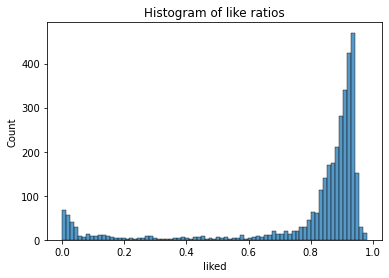

In [6]:
_ = sns.histplot(video_df).set(title='Histogram of like ratios')

In [7]:
def transform_values(i,n,prior=1/2):
    return (i*(n-1)+prior)/n

In [8]:
prior_a, prior_b, loc, scale = beta.fit([transform_values(i, len(train_videos.values),1/2)
                                          for i in train_videos.values], floc=0, fscale=1)

In [9]:
prior_a *= 10
prior_b *= 10
print(prior_a, prior_b)

14.270965891341989 5.916156493565227


In [10]:
-0.2*np.array([prior_a, prior_b]) + 1.2*np.array([1,1])

array([-1.65419318,  0.0167687 ])

## Load in and sanitize simulation results

In [11]:
dir_dict = {
    'sims_opt': 'optimistic', 
    'sims_standard': 'standard', 
#     'sims_standard_two': 'standard_two',
    'sims_strong': 'strong'
}

eta_dict = [
    0.0,
#     0.1,
#     0.2,
    0.3,
#     0.4,
#     0.5,
    0.6,
#     0.7,
#     0.8,
#     0.9,
    1.0
]

In [12]:
data_dict = dict()

for val in eta_dict:
    for k in dir_dict:
        data_dict[(val, dir_dict[k])] = np.load(f'{k}/sim_data_alpha_{val}.npy',allow_pickle=True)[()]
        for l in copy.deepcopy(list(data_dict[(val,dir_dict[k])].keys())):
            if type(l)==tuple:
                data_dict[(val,dir_dict[k])][l[0]] = data_dict[(val,dir_dict[k])].pop(l)

In [13]:
# there has to be a more efficient way to process this data!

market_dict = dict()

for val in eta_dict:
    for k in dir_dict:
        print(f"processing key {(val, k)}")
        market_data = np.load(f'{k}/market_id_data_{val}.npy',allow_pickle=True)[()].astype(float)
        market_dict[(val, dir_dict[k])] = market_data
#         for i in range(market_data.shape[0]):
#             for j in range(market_data.shape[1]):
#                 market_data[i,j] = video_df[market_data[i,j]]
#         market_dict[(val,dir_dict[k])] = np.max(market_data,axis=1)

processing key (0.0, 'sims_opt')
processing key (0.0, 'sims_standard')
processing key (0.0, 'sims_strong')
processing key (0.3, 'sims_opt')
processing key (0.3, 'sims_standard')
processing key (0.3, 'sims_strong')
processing key (0.6, 'sims_opt')
processing key (0.6, 'sims_standard')
processing key (0.6, 'sims_strong')
processing key (1.0, 'sims_opt')
processing key (1.0, 'sims_standard')
processing key (1.0, 'sims_strong')


In [14]:
market_dict_top_item = dict()

for val in eta_dict:
    for k in dir_dict:
        print(f"processing key {(val, k)}")
        market_data = np.load(f'{k}/market_id_data_{val}.npy',allow_pickle=True)[()].astype(float)
        market_dict_top_item[(val, dir_dict[k])] = market_data
        for i in range(market_data.shape[0]):
            for j in range(market_data.shape[1]):
                market_data[i,j] = video_df[market_data[i,j]]
        market_dict_top_item[(val,dir_dict[k])] = np.max(market_data,axis=1)

processing key (0.0, 'sims_opt')
processing key (0.0, 'sims_standard')
processing key (0.0, 'sims_strong')
processing key (0.3, 'sims_opt')
processing key (0.3, 'sims_standard')
processing key (0.3, 'sims_strong')
processing key (0.6, 'sims_opt')
processing key (0.6, 'sims_standard')
processing key (0.6, 'sims_strong')
processing key (1.0, 'sims_opt')
processing key (1.0, 'sims_standard')
processing key (1.0, 'sims_strong')


In [15]:
def get_plays_dict_from_market_data_loss_min(marketdict, video_df):
    datadict = {}
    prev_mkt = marketdict[0,:]
    counts = [[0] for _ in range(marketdict.shape[1])]
    welfare = 0
    for i in range(marketdict.shape[0]):
        if (i+1) % (marketdict.shape[0]//20) == 0:
            print(f'iteration {i+1}/{marketdict.shape[0]}')
        curr_market = marketdict[i,:]
        best_vid_index = np.argmax(video_df[curr_market].values)
        welfare += video_df[curr_market[best_vid_index]]
        for j in range(marketdict.shape[1]):
            if marketdict[i,j] not in datadict:
                datadict[marketdict[i,j]] = []
            
            if marketdict[i,j] != prev_mkt[j]:
                datadict[prev_mkt[j]].append(np.array(counts[j]))
                counts[j] = [0]
                
            if j == best_vid_index:
                counts[j].append(copy.deepcopy(counts[j][-1])+1)
            else:
                counts[j].append(copy.deepcopy(counts[j][-1]))
                
        prev_mkt = curr_market
        
    for j in range(marketdict.shape[1]):
        datadict[prev_mkt[j]].append(np.array(counts[j]))
        
    return datadict, welfare


In [16]:
oracle_plays_dict, oracle_welfare = get_plays_dict_from_market_data_loss_min(market_dict[(0.0,'standard')],video_df)

iteration 50000/1000000
iteration 100000/1000000
iteration 150000/1000000
iteration 200000/1000000
iteration 250000/1000000
iteration 300000/1000000
iteration 350000/1000000
iteration 400000/1000000
iteration 450000/1000000
iteration 500000/1000000
iteration 550000/1000000
iteration 600000/1000000
iteration 650000/1000000
iteration 700000/1000000
iteration 750000/1000000
iteration 800000/1000000
iteration 850000/1000000
iteration 900000/1000000
iteration 950000/1000000
iteration 1000000/1000000


In [17]:
def get_plays_dict_from_market_data_var_min(marketdict, video_df):
    datadict = {}
    prev_mkt = marketdict[0,:]
    counts = [[0] for _ in range(marketdict.shape[1])]
    welfare = 0
    for i in range(marketdict.shape[0]):
        if (i+1) % (marketdict.shape[0]//20) == 0:
            print(f'iteration {i+1}/{marketdict.shape[0]}')
        curr_market = marketdict[i,:]
        best_vid_index = np.argmax([-count[-1]/len(count) for count in counts])
        welfare += video_df[curr_market[best_vid_index]]
        for j in range(marketdict.shape[1]):
            if marketdict[i,j] not in datadict:
                datadict[marketdict[i,j]] = []
            
            if marketdict[i,j] != prev_mkt[j]:
                datadict[prev_mkt[j]].append(np.array(counts[j]))
                counts[j] = [0]
                
            if j == best_vid_index:
                counts[j].append(copy.deepcopy(counts[j][-1])+1)
            else:
                counts[j].append(copy.deepcopy(counts[j][-1]))
                
        prev_mkt = curr_market
        
    for j in range(marketdict.shape[1]):
        datadict[prev_mkt[j]].append(np.array(counts[j]))
        
    return datadict, welfare


In [18]:
var_min_plays_dict, var_min_welfare = get_plays_dict_from_market_data_var_min(market_dict[(0.0,'standard')],video_df)

iteration 50000/1000000
iteration 100000/1000000
iteration 150000/1000000
iteration 200000/1000000
iteration 250000/1000000
iteration 300000/1000000
iteration 350000/1000000
iteration 400000/1000000
iteration 450000/1000000
iteration 500000/1000000
iteration 550000/1000000
iteration 600000/1000000
iteration 650000/1000000
iteration 700000/1000000
iteration 750000/1000000
iteration 800000/1000000
iteration 850000/1000000
iteration 900000/1000000
iteration 950000/1000000
iteration 1000000/1000000


## Plotting the central figure that we want to base our results on - the pareto curve

In [19]:
def gini_coeff(a):
    temp = np.sort(a)
    n = temp.shape[0]
    counts = np.array(range(1,n+1))
    asum = np.sum(temp)
    return 1/n*(n+1 - 2*((n+1)*np.sum(temp) - temp @ counts)/asum)

In [20]:
def get_quality_array(datadict, value_df):
    a = []
    for l in datadict:
        for life in datadict[l]:
            a.append(np.array([value_df[l]]*(int(np.round(np.sum(life[-1,:]) - np.sum(life[0,:]))))))
            
    return np.hstack(a)

In [21]:
def get_plays_array(datadict):
    a = []
    for l in datadict:
        for lifespan in datadict[l]:
            final_score = lifespan[-1]
            a.append((final_score[0] + final_score[1] - np.sum(lifespan[0]))/lifespan.shape[0])
            
    return np.array(a)

In [22]:
def get_average_plays_variance(datadict):
    a = []
    for l in datadict:
        l_array = []
        for lifespan in datadict[l]:
            if lifespan.shape[0] > 1:
                l_array.append((np.sum(lifespan[-1]) - np.sum(lifespan[0]))/(lifespan.shape[0]-1))
        
        a.append(np.std(l_array))
        
    return np.mean(a)


In [23]:
for k in copy.deepcopy(list(oracle_plays_dict.keys())):
    oracle_plays_dict[int(k)] = oracle_plays_dict.pop(k)

In [24]:
for k in copy.deepcopy(list(var_min_plays_dict.keys())):
    var_min_plays_dict[int(k)] = var_min_plays_dict.pop(k)

In [25]:
df_list = []
for k in data_dict:
    pareto_df = pd.DataFrame()
    prior_a, prior_b = data_dict[k][list(data_dict[k].keys())[0]][0][0,:]
    total_val, total_plays = 0, 0
    
#     pareto_df = pd.DataFrame([[k[0], 
#                               k[1],
#                               prior_a, 
#                               prior_b, 
#                               np.sum(market_dict[k] - get_quality_array(data_dict[k], video_df)),
#                               gini_coeff(get_plays_array(data_dict[k]))]],
#                               columns=['eta', 'dataset', 'prior_a', 'prior_b', 'regret', 'gini_coeff'])

    pareto_df = pd.DataFrame([[k[0], 
                              k[1],
                              prior_a, 
                              prior_b, 
                              np.sum(market_dict_top_item[k] - get_quality_array(data_dict[k], video_df)),
                              get_average_plays_variance(data_dict[k])]],
                              columns=['eta', 'dataset', 'prior_a', 'prior_b', 'regret', 'var'])
    
    df_list.append(pareto_df)

In [26]:
oracle_df = pd.DataFrame([[0, 
                           'oracle',
                           0, 
                           0, 
                           np.sum(market_dict_top_item[(0.0, 'standard')]) - oracle_welfare,
                           get_average_plays_variance(oracle_plays_dict)]],
                           columns=['eta', 'dataset', 'prior_a', 'prior_b', 'regret', 'var'])

In [27]:
var_min_df = pd.DataFrame([[0, 
                           'var_min_oracle',
                           0, 
                           0, 
                           np.sum(market_dict_top_item[(0.0, 'standard')]) - var_min_welfare,
                           get_average_plays_variance(var_min_plays_dict)]],
                           columns=['eta', 'dataset', 'prior_a', 'prior_b', 'regret', 'var'])

In [28]:
pareto_df = pd.concat(df_list + [oracle_df, var_min_df])
# pareto_df = pareto_df[(pareto_df['dataset']=='standard') | (pareto_df['dataset']=='standard_two')]

In [29]:
pareto_df

,eta,dataset,prior_a,prior_b,regret,var
0,0.0,optimistic,1.000000,1.000000,5.436845e+04,0.095481
0,0.0,standard,1.000000,1.000000,5.412665e+04,0.095581
0,0.0,strong,1.000000,1.000000,5.453488e+04,0.095398
0,0.3,optimistic,1.128129,0.877485,5.629878e+04,0.097315
0,0.3,standard,4.981290,2.474847,5.805809e+04,0.090181
0,0.3,strong,3.700000,3.700000,5.215083e+04,0.103593
0,0.6,optimistic,1.256258,0.754969,5.839715e+04,0.101552
0,0.6,standard,8.962580,3.949694,6.035466e+04,0.089609
0,0.6,strong,6.400000,6.400000,5.482641e+04,0.108576
0,1.0,optimistic,1.427097,0.591616,6.033592e+04,0.108679


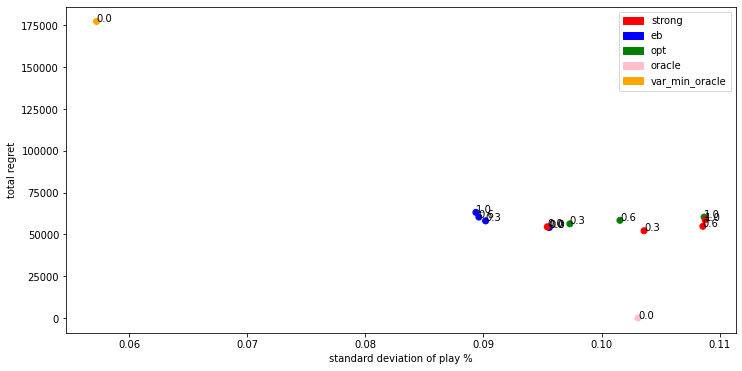

In [30]:


x = list(pareto_df['var'])
y = list(pareto_df['regret'])
colors = list(pareto_df['dataset'])

color_dict = {"standard":"blue", 
              "strong":"red", 
              "optimistic":"green", 
              'oracle':"pink",
              'var_min_oracle':"orange",
              'superopt':'brown',
              'standard_two':'black'}

fig,ax = plt.subplots()
fig.set_size_inches(12,6)
ax.scatter(x, y, color=[color_dict[item] for item in colors])
plt.xlabel('standard deviation of play %')
plt.ylabel('total regret')

labels = pareto_df['eta'].to_numpy()

red_patch = mpatches.Patch(color='red', label='strong')
blue_patch = mpatches.Patch(color='blue', label='eb')
green_patch = mpatches.Patch(color='green', label='opt')
pink_patch = mpatches.Patch(color='pink', label='oracle')
orange_patch = mpatches.Patch(color='orange', label='var_min_oracle')
plt.legend(handles=[red_patch, blue_patch, green_patch, pink_patch, orange_patch])

for i in range(labels.shape[0]):
    ax.annotate(f"{labels[i]}", (x[i], y[i]))

## How does this trade-off in efficiency and variance manifest, exactly? Who are the winners and losers?

In [31]:
def get_binned_plays_array(datadict, video_df, num_quants, cutoff=0):
    plays_data = [[] for _ in range(num_quants)]
    quantile_df = pd.cut(video_df, np.linspace(0,1,num_quants+1), labels=range(num_quants))
    for item in datadict:
        quant = plays_data[quantile_df[item]]
        
        for lifespan in datadict[item]:
            if lifespan.shape[0] > cutoff:
                final_score = lifespan[-1]
                quant.append((final_score[0] + final_score[1] - np.sum(lifespan[0]))/lifespan.shape[0])

    return plays_data


In [32]:
num_quants = 20
plays_data = {}
for k in data_dict:
    if 'standard' in k:
        plays_data[k[0]] = get_binned_plays_array(data_dict[k], video_df, num_quants, cutoff=10)
  

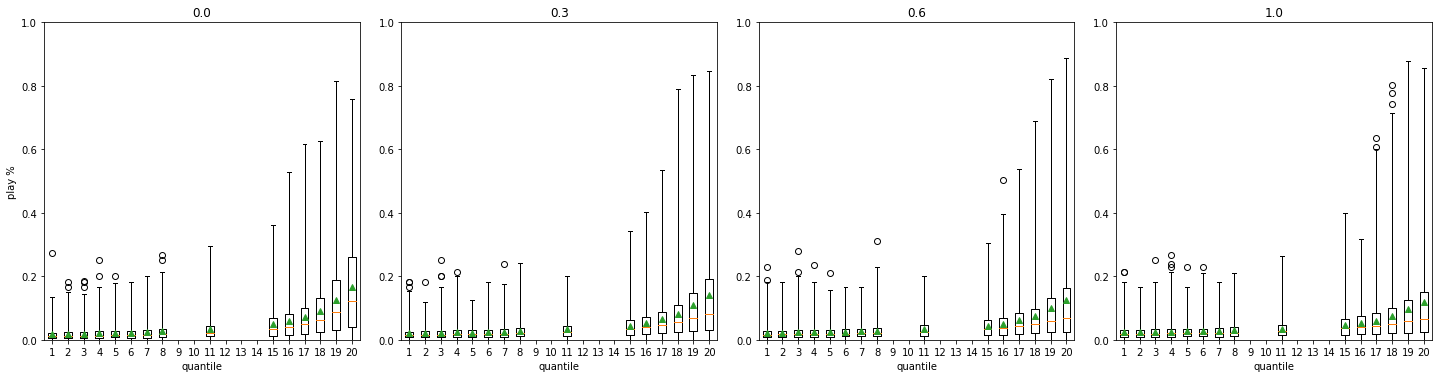

In [33]:
keys_to_plot = [0.0, 0.3, 0.6, 1.0]

f,axes = plt.subplots(1, len(keys_to_plot))
f.set_size_inches(20,5)
f.tight_layout(h_pad=5)
for i in range(len(keys_to_plot)):
    plt.sca(axes[i])
    curr_dataset = plays_data[keys_to_plot[i]]
    plt.ylim((0,1))
    plt.title(keys_to_plot[i])
    if i==0:
        plt.ylabel('play %')
    plt.boxplot(curr_dataset, labels=range(1,num_quants+1), whis=8, showmeans=True)
    plt.xlabel('quantile')

In [34]:
df_dict = {}
for i in range(len(keys_to_plot)):
    column = [np.mean(item) for item in plays_data[keys_to_plot[i]]]
    df_dict[keys_to_plot[i]] = column

print('means')
pd.DataFrame(df_dict)

means


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,0.0,0.3,0.6,1.0
0,0.017237,0.020131,0.021542,0.023449
1,0.018083,0.019943,0.022151,0.023840
2,0.018803,0.021824,0.023051,0.024385
3,0.020331,0.023643,0.023741,0.026057
4,0.020735,0.022653,0.024175,0.026530
5,0.021853,0.023214,0.025789,0.026284
6,0.023027,0.025615,0.026435,0.028093
7,0.026181,0.028336,0.028194,0.029400
8,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN


In [35]:
df_dict = {}
for i in range(len(keys_to_plot)):
    column = [np.std(item) for item in plays_data[keys_to_plot[i]]]
    df_dict[keys_to_plot[i]] = column

print('stds')
pd.DataFrame(df_dict)

stds


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,0.0,0.3,0.6,1.0
0,0.017098,0.019213,0.021275,0.022342
1,0.019149,0.018967,0.021439,0.023117
2,0.018831,0.021816,0.023041,0.023716
3,0.021739,0.022708,0.023867,0.026874
4,0.022016,0.020523,0.023765,0.024390
5,0.023047,0.022588,0.023886,0.025486
6,0.024602,0.024516,0.024567,0.028448
7,0.028840,0.028519,0.028976,0.028205
8,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN


## At what points in product lifetime are the effects of changing the prior most pronounced?

In [36]:
def get_num_plays(datadict, horizon=10, plays_cap=3):
    hist = [0 for _ in range(plays_cap+1)]
    for item in datadict:
        for lifespan in datadict[item]:
            if lifespan.shape[0] >= horizon:
                num_plays = int(np.sum(lifespan[horizon-1,:] - lifespan[0,:]))
                if num_plays >= plays_cap:
                    num_plays=plays_cap
                    
                hist[num_plays] += 1
                
    return np.array(hist)

In [37]:
horizon=25
plays_cap=6

early_plays_dict = dict()
for k in data_dict:
    if 'standard' in k:
        early_plays_dict[k[0]] = get_num_plays(data_dict[k], horizon, plays_cap)

KeyError: 0.2

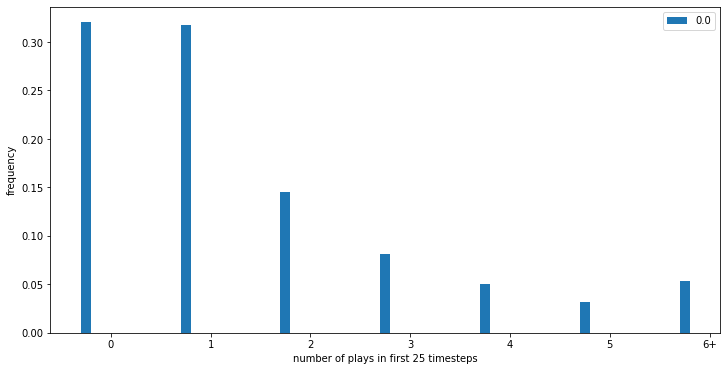

In [38]:
keys_to_plot = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

x = [str(i) for i in range(plays_cap+1)]
x[-1] = x[-1] + '+'
fig, ax = plt.subplots()

fig.set_size_inches(12,6)

for i in range(len(keys_to_plot)):
    curr_dataset = early_plays_dict[keys_to_plot[i]]/np.sum(early_plays_dict[keys_to_plot[i]])
    ax.bar(x=[k + 0.1*i for k in range(plays_cap+1)],height=curr_dataset, width=0.1, label=keys_to_plot[i])
    ax.set_xticks([k + 0.25 for k in range(plays_cap+1)], x)
    ax.legend()
    plt.ylabel('frequency')
    plt.xlabel(f'number of plays in first {horizon} timesteps')